# Import packages #

In [1]:
import nibabel as nib
import scipy.ndimage as ndi
import matplotlib.pyplot as plt
import os
import pandas as pd
import seaborn as sns
import numpy as np
import glob, random
from scipy import stats

# Identifying missing values in demographic data

Download demographic of data.

In [2]:
# dfLongitudinal = pd.read_excel("/Volumes/Seagate/FH-Kaernten/AANDL/oasis_longitudinal_demographics.xlsx")
dfLongitudinal = pd.read_excel("/Users/sutatippittayapong/Library/CloudStorage/OneDrive-FHKärnten-gemeinnützigeGesellschaftmbH/Artificial Neural Networks and Deep Learning/oasis_longitudinal_demographics.xlsx")
dfLongitudinal.sample(3)

,Subject ID,MRI ID,Group,Visit,MR Delay,M/F,Hand,Age,EDUC,SES,MMSE,CDR,eTIV,nWBV,ASF
317,OAS2_0157,OAS2_0157_MR2,Demented,2,764,F,R,75,12,2.0,18.0,1.0,1478.520000,0.656862,1.187000
360,OAS2_0182,OAS2_0182_MR2,Demented,2,776,M,R,75,12,NaN,20.0,0.5,1653.728947,0.696097,1.061238
30,OAS2_0017,OAS2_0017_MR3,Nondemented,3,617,M,R,81,12,3.0,27.0,0.5,1813.670000,0.759250,0.967650


Find missing value

In [3]:
dfLongitudinal.isna().sum()
# dfLongitudinal[dfLongitudinal.isnull().any(axis=1)]

Subject ID     0
MRI ID         0
Group          0
Visit          0
MR Delay       0
M/F            0
Hand           0
Age            0
EDUC           0
SES           19
MMSE           2
CDR            0
eTIV           0
nWBV           0
ASF            0
dtype: int64

Summarizing 'SES' and 'MMSE' data.

In [4]:
dfLongitudinal[["SES","MMSE"]].describe(include="all")

,SES,MMSE
count,354.000000,371.000000
mean,2.460452,27.342318
std,1.134005,3.683244
min,1.000000,4.000000
25%,2.000000,27.000000
50%,2.000000,29.000000
75%,3.000000,30.000000
max,5.000000,30.000000


<Axes: >

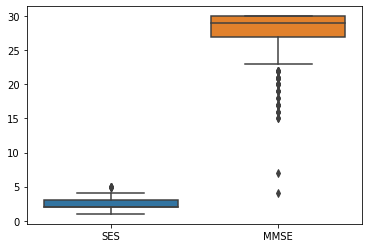

In [5]:
sns.boxplot(dfLongitudinal[["SES","MMSE"]])

Impute "SES" missing value with Mean as the data is not skew.

In [6]:
dfLongitudinal["SES"] = dfLongitudinal["SES"].fillna(dfLongitudinal["SES"].mean())

Impute "MMSE" missing value with Mode as the data is skew.

In [7]:
dfLongitudinal["MMSE"] = dfLongitudinal["MMSE"].fillna(dfLongitudinal["MMSE"].mode()[0])

In [8]:
dfLongitudinal.isna().sum()

Subject ID    0
MRI ID        0
Group         0
Visit         0
MR Delay      0
M/F           0
Hand          0
Age           0
EDUC          0
SES           0
MMSE          0
CDR           0
eTIV          0
nWBV          0
ASF           0
dtype: int64

# Identifying class imbalance #

Get unique "Group" value.

In [9]:
print(dfLongitudinal["Group"].unique())

['Nondemented' 'Demented' 'Converted']


Visualize number of MR images by Group.

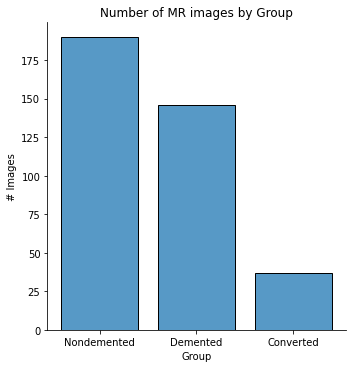

In [10]:
ax = sns.displot(data = dfLongitudinal
                 , x="Group"
                 , shrink=.8)
ax.set(ylabel="# Images",
      title="Number of MR images by Group")
plt.show()

<span style="color:red">The number of MR images in each group are different. Data augmented is reqiured to be prepared for model training.</span>

# Plotting Image Size #

Load MR image and get voxel size.

In [11]:
dataPath = "/Users/sutatippittayapong/Library/CloudStorage/OneDrive-FHKärnten-gemeinnützigeGesellschaftmbH/Artificial Neural Networks and Deep Learning/Data"
subject = []
files = os.listdir(dataPath)
i = 0
for file in files:
    if file.endswith(".img"):
        subject.append(nib.load(os.path.join(dataPath,file)))
        dfLongitudinal["X"] = subject[i].shape[0]
        dfLongitudinal["Y"] = subject[i].shape[1]
        dfLongitudinal["Z"] = subject[i].shape[2]
        i += 1

Plot image voxel size.

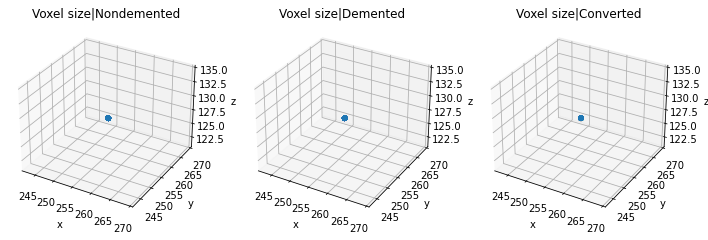

In [12]:
fig = plt.figure(figsize=(12,12))
ax = fig.add_subplot(131, projection='3d')

ax.scatter(dfLongitudinal[dfLongitudinal["Group"]=="Nondemented"]["X"]
           ,dfLongitudinal[dfLongitudinal["Group"]=="Nondemented"]["Y"]
           ,dfLongitudinal[dfLongitudinal["Group"]=="Nondemented"]["Z"])
ax.set(xlabel="x", ylabel="y", zlabel="z"
      ,title="Voxel size|Nondemented")

ax = fig.add_subplot(132, projection='3d')

ax.scatter(dfLongitudinal[dfLongitudinal["Group"]=="Demented"]["X"]
           ,dfLongitudinal[dfLongitudinal["Group"]=="Demented"]["Y"]
           ,dfLongitudinal[dfLongitudinal["Group"]=="Demented"]["Z"])
ax.set(xlabel="x", ylabel="y", zlabel="z"
      ,title="Voxel size|Demented")

ax = fig.add_subplot(133, projection='3d')

ax.scatter(dfLongitudinal[dfLongitudinal["Group"]=="Converted"]["X"]
           ,dfLongitudinal[dfLongitudinal["Group"]=="Converted"]["Y"]
           ,dfLongitudinal[dfLongitudinal["Group"]=="Converted"]["Z"])
ax.set(xlabel="x", ylabel="y", zlabel="z"
      ,title="Voxel size|Converted")

plt.show()

<span style="color:blue">All MR images have the same voxel size.</span>

# View image header (metadata) #

In [13]:
print(subject[0].header)

<class 'nibabel.nifti1.Nifti1PairHeader'> object, endian='>'
sizeof_hdr      : 348
data_type       : b''
db_name         : b''
extents         : 0
session_error   : 0
regular         : b''
dim_info        : 57
dim             : [  4 256 256 128   1   0   0   0]
intent_p1       : 0.0
intent_p2       : 0.0
intent_p3       : 0.0
intent_code     : none
datatype        : float32
bitpix          : 32
slice_start     : 0
pixdim          : [-1.    1.    1.    1.25  0.    0.    0.    0.  ]
vox_offset      : 0.0
scl_slope       : nan
scl_inter       : nan
slice_end       : 0
slice_code      : unknown
xyzt_units      : 10
cal_max         : 0.0
cal_min         : 0.0
slice_duration  : 0.0
toffset         : 0.0
glmax           : 0
glmin           : 0
descrip         : b''
aux_file        : b''
qform_code      : scanner
sform_code      : unknown
quatern_b       : 0.5
quatern_c       : 0.5
quatern_d       : 0.5
qoffset_x       : 78.125
qoffset_y       : -127.5
qoffset_z       : -126.5
srow_x          

# Viewing a Sampling of Medical Images #

Random select 5 images of each group

In [14]:
seed=1234

# Nondemented group
sampleNondemented = random.Random(seed).sample(dfLongitudinal[dfLongitudinal["Group"]=="Nondemented"]["MRI ID"].tolist(), k=5)

volumeNondemented = []
for image in sampleNondemented:
    for s in subject:
        if s.get_filename() == os.path.join(dataPath,image+".nifti.img"):
            volumeNondemented.append(s.get_fdata())
            
# Demented group
sampleDemented = random.Random(seed).sample(dfLongitudinal[dfLongitudinal["Group"]=="Demented"]["MRI ID"].tolist(), k=5)

volumeDemented = []
for image in sampleDemented:
    for s in subject:
        if s.get_filename() == os.path.join(dataPath,image+".nifti.img"):
            volumeDemented.append(s.get_fdata())
            
# Converted group
sampleConverted = random.Random(seed).sample(dfLongitudinal[dfLongitudinal["Group"]=="Converted"]["MRI ID"].tolist(), k=5)

volumeConverted = []
for image in sampleConverted:
    for s in subject:
        if s.get_filename() == os.path.join(dataPath,image+".nifti.img"):
            volumeConverted.append(s.get_fdata())

### Raw Comparison ###

To view MR image of each group.

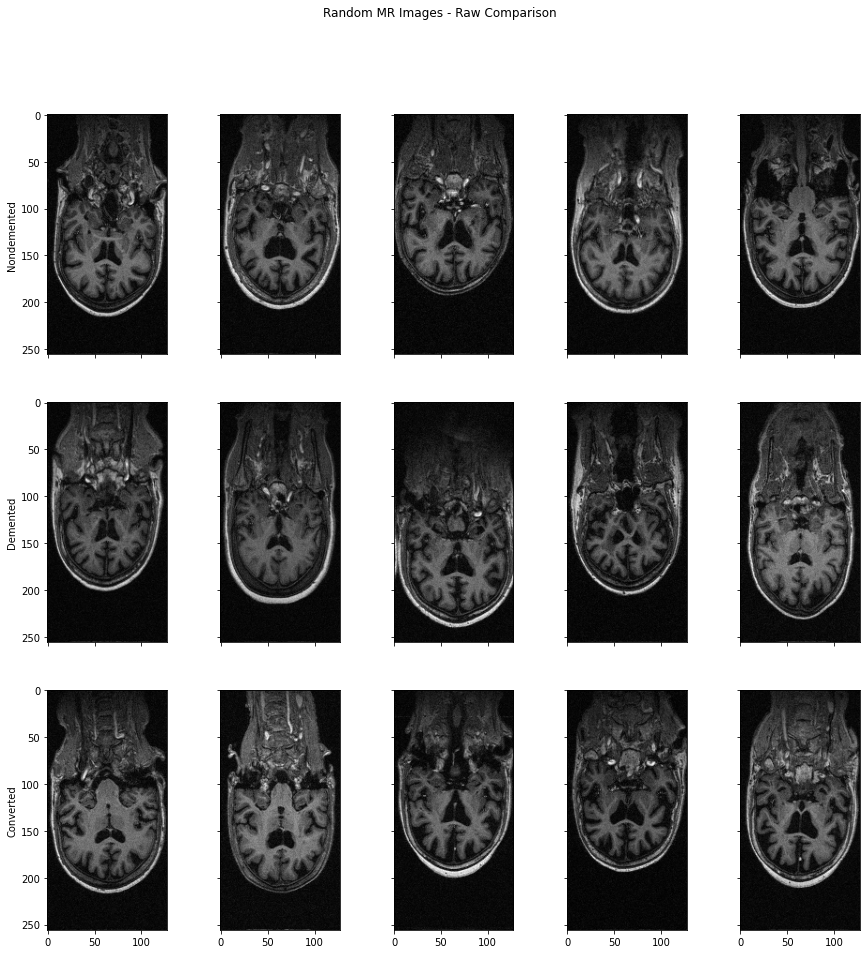

In [15]:
fig, axs = plt.subplots(3, 5, figsize=(15,15))
fig.suptitle('Random MR Images - Raw Comparison')

row, col = 0, 0
for vol in volumeNondemented:
    axs[row,col].imshow(vol[128,:,:], cmap='gray')
    col += 1

row += 1    
col = 0
for vol in volumeDemented:
    axs[row,col].imshow(vol[128,:,:], cmap='gray')
    col += 1

row += 1    
col = 0
for vol in volumeConverted:
    axs[row,col].imshow(vol[128,:,:], cmap='gray')
    col += 1

idx = 0
for ax in axs.flat:
    if idx<5:
        ax.set(ylabel='Nondemented')
    elif idx<10:
        ax.set(ylabel='Demented')
    else:
        ax.set(ylabel='Converted')
    idx += 1

# Hide x labels and tick labels for top plots and y ticks for right plots.
for ax in axs.flat:
    ax.label_outer()

plt.show()

<span style="color:blue">It can be seen that there are differently of brain tissue between Nondemented and Demented.</span>

### Average Image ###

To visualize avarage image intensity of each group.

In [16]:
packNondemented = np.stack(volumeNondemented, axis=0)
packDemented = np.stack(volumeDemented, axis=0)
packConverted = np.stack(volumeConverted, axis=0)

In [17]:
meanNondemented = np.mean(packNondemented, axis=0)
meanDemented = np.mean(packDemented, axis=0)
meanConverted = np.mean(packConverted, axis=0)

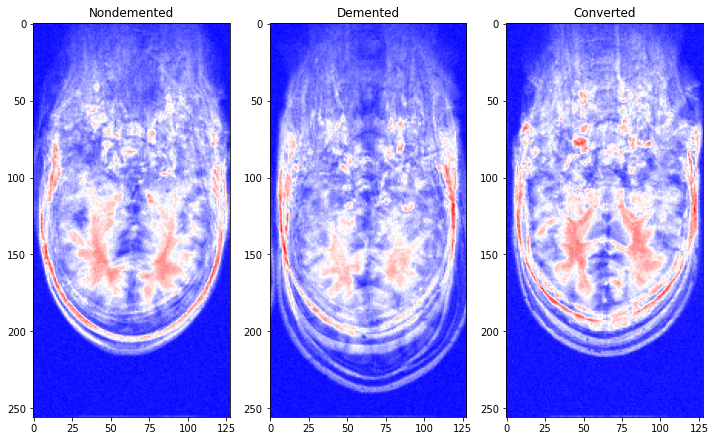

In [18]:
fig = plt.figure(figsize=(12,12))

ax = fig.add_subplot(131)
ax.imshow(meanNondemented[128,:,:], cmap='bwr')
ax.set(title="Nondemented")

ax = fig.add_subplot(132)
ax.imshow(meanDemented[128,:,:], cmap='bwr')
ax.set(title="Demented")

ax = fig.add_subplot(133)
ax.imshow(meanConverted[128,:,:], cmap='bwr')
ax.set(title="Converted")

plt.show()

<span style="color:blue">Nondemented has brain tissue more than Converted and Demented groups.</span>

### Brain Voxel Intensity ###

To visualize image intensity distribution.

In [19]:
flatNondemented = meanNondemented.ravel()
flatDemented = meanDemented.ravel()
flatConverted = meanConverted.ravel()

dfNondemented = pd.DataFrame({"Group": "Nondemented", "Intensity": flatNondemented})
dfDemented = pd.DataFrame({"Group": "Demented", "Intensity": flatDemented})
dfConverted = pd.DataFrame({"Group": "Converted", "Intensity": flatConverted})

dfAllGroup = pd.concat([dfNondemented, dfDemented, dfConverted])

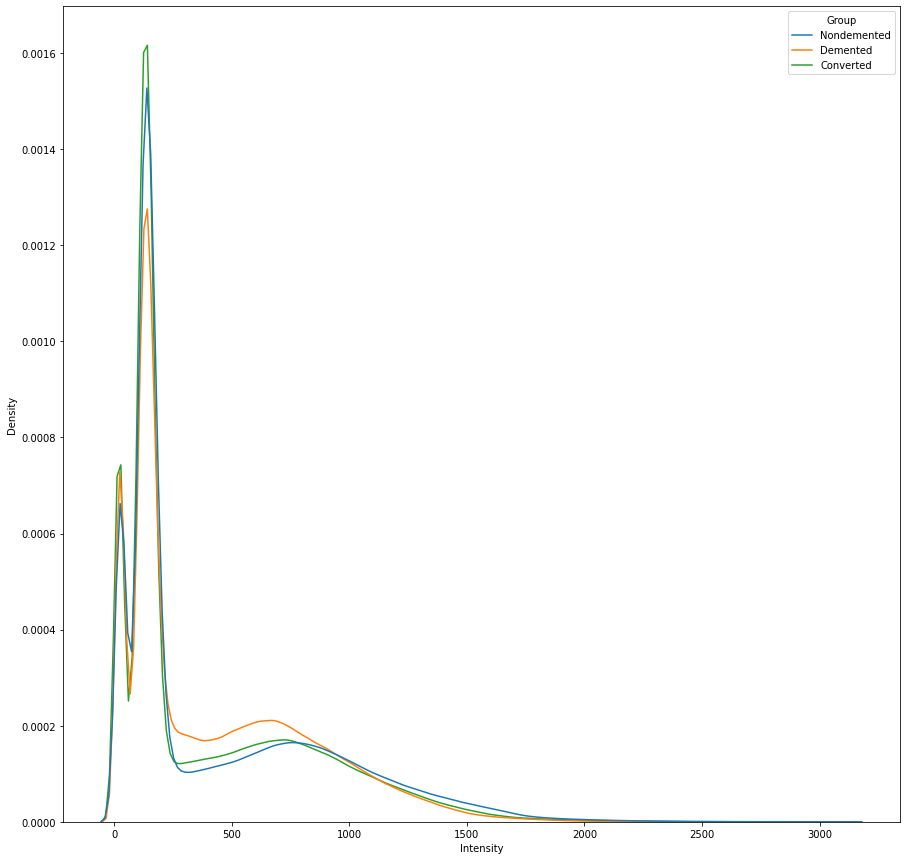

In [20]:
fig = plt.figure(figsize=(15,15))

# sns.histplot(data=dfAllGroup, x="Intensity", hue="Group")
sns.kdeplot(data=dfAllGroup, x="Intensity", hue="Group")

plt.show()

<span style="color:blue">Nondemented has brain tissue (high intensity) more than Converted and Demented groups.</span>

# Statistical Test #

H0: There are no different of average image intensity among 3 groups.

In [21]:
stat, p = stats.kruskal(flatNondemented, flatDemented, flatConverted)
print('Statistics=%.3f, p=%.3f' % (stat, p))
# interpret
alpha = 0.05
if p > alpha:
 print('Same distributions (fail to reject H0)')
else:
 print('Different distributions (reject H0)')

Statistics=52392.782, p=0.000
Different distributions (reject H0)


<span style="color:blue">There are significantly different of brain tissue among Nondemented, Demented and Converted groups. (Kruskal Test, p &lt; 0.5)</span>

<span style="color:blue"><b>Therefore, this dataset can be used for brain degenerative disease classification.</span>

# References #

https://neuraldatascience.io/8-mri/nifti.html

https://nifti.nimh.nih.gov/pub/dist/src/niftilib/nifti1.h

https://nipy.org/nibabel/coordinate_systems.html

https://towardsdatascience.com/exploratory-data-analysis-ideas-for-image-classification-d3fc6bbfb2d2

https://www.kaggle.com/code/ayuraj/brain-tumor-eda-and-interactive-viz-with-w-b/notebook